In [425]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from matplotlib.colors import ListedColormap

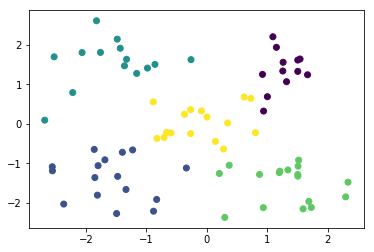

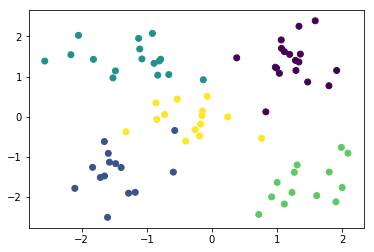

In [497]:
input_features = 2
mus_1 = np.array([1, -1, -1, 1, 0])*1.5
mus_2 = np.array([1, -1, 1, -1, 0])*1.5
vars_1 = np.array([1, 1, 1, 1, 1])/2
vars_2 = np.array([1, 1, 1, 1, 1])/2
N = 30
X = np.array([]).reshape(0,input_features)
y = np.array([]).reshape(0, 1)
for i in range(len(mus_1)):
    G1 = np.random.normal(mus_1[i], vars_1[i], N)
    G2 = np.random.normal(mus_2[i], vars_2[i], N)
    X_cat = np.vstack([G1,G2]).T
    X = np.vstack([X,X_cat])
    y_cat = np.ones(N).reshape(N,1)*i
    y = np.vstack([y,y_cat])
y = y.reshape(N*len(mus_1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.show()
plt.scatter(X_test[:,0], X_test[:,1], c=y_test)
plt.show()

In [498]:
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Activation
from helper import PlotLosses
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal

In [499]:
hidden_units = 20
output_size = len(mus_1)
model = Sequential()
model.add(Dense(hidden_units,input_dim=input_features))
model.add(Activation('sigmoid'))
model.add(Dense(output_size))
model.add(Activation('softmax'))
model.summary()

lr = 0.04 
batch_size = 20
epochs = 1000

#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr)

# Lo compilo
model.compile(loss = 'categorical_crossentropy', optimizer=selectedOptimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 20)                60        
_________________________________________________________________
activation_51 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 5)                 105       
_________________________________________________________________
activation_52 (Activation)   (None, 5)                 0         
Total params: 165
Trainable params: 165
Non-trainable params: 0
_________________________________________________________________


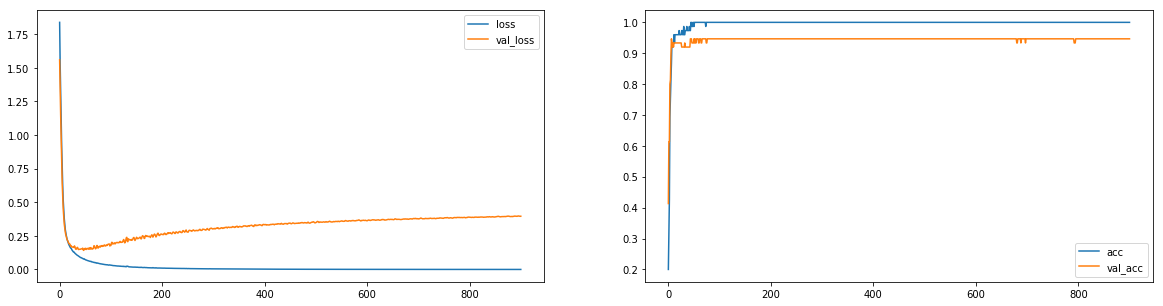

In [500]:
# Se puede tocar plot_interval para acelerar el proceso, el resto recomendamos no tocarlo
plot_losses = PlotLosses(plot_interval=100, 
                         evaluate_interval=None, 
                         x_val=X_test, 
                         y_val_categorical=y_test_cat)
model.fit(X_train, 
          y_train_cat, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=0, 
          validation_data=(X_test, y_test_cat), 
          callbacks=[plot_losses],
         )

56352/57840 [============================>.] - ETA: 0s

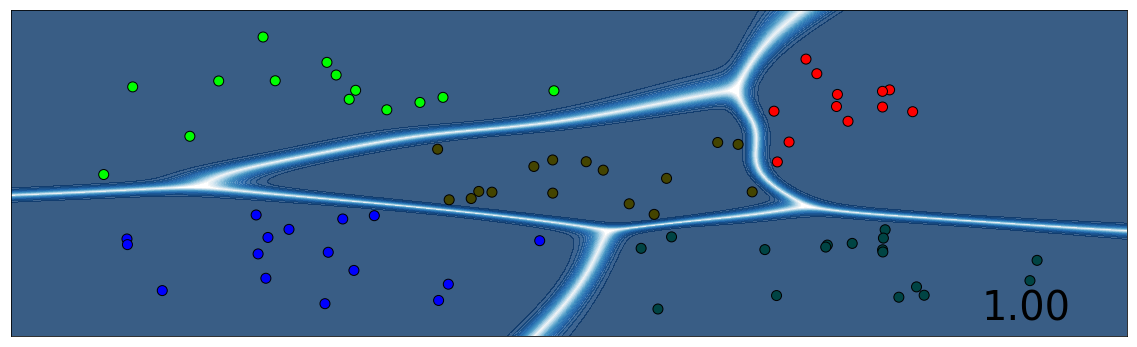

In [501]:
def plot_boundaries_keras(X_train, y_train, score, probability_func, degree=None, bias=False, h = .02, ax = None, margin=0.5):
    y_train_cat = to_categorical(y_train)
    colors_options = ['#FF0000', '#0000FF', '#00FF00', '#004444', '#444400']
    X = X_train
    x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
    y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    if ax is None:
        ax = plt.subplot(1, 1, 1)
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    
    if degree is not None:
        polynomial_set = get_polynimial_set(np.c_[xx.ravel(), yy.ravel()], degree = degree, bias=bias)
        Zaux = probability_func(polynomial_set)
    else:
        Zaux = probability_func(np.c_[xx.ravel(), yy.ravel()])
        # Z = Z_aux[:, 1]
    
    # if Zaux.shape[1] == 2:
        # Es un polinomio
        # Z = Zaux[:, 1]
    # else:
        # No es un polinomio
        # Z = Zaux[:, 2]

    # Put the result into a color plot
    Z_reshaped = Zaux.reshape(xx.shape[0], xx.shape[1], y_train_cat.shape[1])
    
    cm_borders = ListedColormap(["#FFFFFFFF", "#000000"])
    cm = plt.cm.RdBu
    my_cmap = cm(np.arange(cm.N))
    my_cmap[:128,-1] = 0
    my_cmap[128:,-1] = 0.8
    my_cmap = ListedColormap(my_cmap)
    
    for i in range(Z_reshaped.shape[2]):
        Z = Z_reshaped[:,:,i]    
        
        cf = ax.contourf(xx, yy, 
                         #Z*(Z>0.5) + (Z<0.5)*0.5, 
                         Z,
                         50, 
                         vmin = 0,
                         vmax = 1,
                         cmap=my_cmap, 
                         #alpha=.9
                        )
        #cf = ax.contourf(xx, yy, (Z>0.48) & (Z<0.52)*1, 
        #                 cmap=cm_borders,)
        
    # plt.colorbar(cf, ax=ax)
    #plt.colorbar(Z,ax=ax)

    # Plot also the training points
    cm_bright = ListedColormap(colors_options[:y_train_cat.shape[1]])
    ax.scatter(X_train[:, 0], X_train[:, 1], 
               c=y_train, 
               cmap=cm_bright,
               edgecolors='k', s=100)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=40, horizontalalignment='right')
    return Zaux, Z
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
Z_aux, Z = plot_boundaries_keras(X_train, y_train, score, model.predict_proba, h =.025)
plt.show()

In [468]:
cm = plt.cm.RdBu
my_cmap = cm(np.arange(cm.N))
my_cmap[:int(cmap.N/2),-1] = 0
my_cmap_last = ListedColormap(my_cmap)

In [383]:
my_cmap

array([[ 0.40392157,  0.        ,  0.12156863,  0.        ],
       [ 0.41545559,  0.00369089,  0.12341407,  0.        ],
       [ 0.42698962,  0.00738178,  0.12525952,  0.        ],
       ..., 
       [ 0.02821992,  0.20484429,  0.40346021,  1.        ],
       [ 0.02391388,  0.19653979,  0.39192618,  1.        ],
       [ 0.01960784,  0.18823529,  0.38039216,  1.        ]])

In [322]:
cmap

In [323]:
my_cmap = cmap(np.arange(cmap.N))

In [326]:
my_cmap[:10,:]

array([[ 0.40392157,  0.        ,  0.12156863,  1.        ],
       [ 0.41545559,  0.00369089,  0.12341407,  1.        ],
       [ 0.42698962,  0.00738178,  0.12525952,  1.        ],
       [ 0.43852364,  0.01107266,  0.12710496,  1.        ],
       [ 0.45005767,  0.01476355,  0.1289504 ,  1.        ],
       [ 0.4615917 ,  0.01845444,  0.13079585,  1.        ],
       [ 0.47312572,  0.02214533,  0.13264129,  1.        ],
       [ 0.48465975,  0.02583622,  0.13448674,  1.        ],
       [ 0.49619377,  0.0295271 ,  0.13633218,  1.        ],
       [ 0.5077278 ,  0.03321799,  0.13817762,  1.        ]])

In [330]:
my_cmap[:int(cmap.N/2),-1] = 0

In [140]:
score = model.evaluate(X_train, y_train)[1]

30/30 [==============================] - 0s


In [178]:
np.argmax(model.predict_proba(X_train), axis = 1).shape

30/30 [==============================] - 0s


(30,)

In [164]:
print(Z_aux.shape)
print(Z.shape)

(14848, 3)
(116, 128)


In [203]:
Z_aux_resh = Z_aux.reshape(116, 128, 3)
indexes = np.argmax(Z_aux_resh, axis=2)


2

In [207]:
Z_aux_resh[indexes==0].shape

(3408, 3)

In [161]:
np.argmax(Z, axis=1)==0
Z[np.argmax(Z, axis=1)==0].shape

(3408, 3)

In [104]:
model.predict_proba(X_train)

30/30 [==============================] - 0s


array([[  1.16418945e-02,   9.86941397e-01,   1.41676969e-03],
       [  9.93273616e-01,   6.72639394e-03,   3.13188373e-08],
       [  1.26736257e-02,   9.86258984e-01,   1.06740079e-03],
       [  3.40670454e-07,   1.24829095e-02,   9.87516701e-01],
       [  9.98687685e-01,   1.31234014e-03,   4.58044225e-09],
       [  2.68994775e-02,   9.72346604e-01,   7.53853470e-04],
       [  1.90255619e-07,   8.13838653e-03,   9.91861343e-01],
       [  4.84633119e-07,   1.58978421e-02,   9.84101713e-01],
       [  8.96947179e-03,   9.89294291e-01,   1.73620332e-03],
       [  2.81116646e-03,   9.89777982e-01,   7.41086714e-03],
       [  2.20425207e-07,   9.09262430e-03,   9.90907192e-01],
       [  9.74049270e-01,   2.59505901e-02,   1.42777168e-07],
       [  6.74447278e-03,   9.89357889e-01,   3.89773259e-03],
       [  9.88573670e-01,   1.14263780e-02,   5.34187414e-08],
       [  3.48596188e-07,   1.23889716e-02,   9.87610698e-01],
       [  5.44741424e-03,   9.90122139e-01,   4.4303895